# DNN

## Package imports

In [959]:

import os.path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

tf.random.set_seed(42)

## Data loading and preparation

### Load data and perform some processing on independent variables
- normalization on numeric features  
    ['age', 'duration', 'campaign', 'previous']  
    
- one-hot encoding on categorical features  
    ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [872]:
def get_processed_data(filename, encoder=None, split_target=True, oversample=False):   
    """Returns processed data for modeling

    Args:
        filename (string): The name of the data file
        encoder (OneHotEncoder, optional): Fitted one-hot encoder. Creates and fit a new one if None
        split_target (bool, optional): Set to True if file contains target data. Defaults to True
        oversample (bool, optional): Oversamples the minority class if True

    Returns:
        Numpy array(s): Processed data
        OneHotEncoder: Fitted encoder if None was given
    """
    
    # determine file type
    extension = os.path.splitext(filename)[1][1:]
    
    # load all data
    if extension == 'xlsx':
        data = pd.read_excel(filename)
    elif extension == 'csv':
        data = pd.read_csv(filename)
    else:
        print(f'Error: Data file type "{extension}" is not supported!')
        return
    
    print(f'Loaded data shape: {data.shape}')
        
    # drop duplicates
    data.drop_duplicates(inplace=True, ignore_index=True)
    print(f'W/o duplicates: {data.shape}')
    
    if split_target:
        predictors = data.iloc[:, 0:-1]
        target = data.iloc[:,-1:]
        
        if oversample:
            predictors, target = perform_oversampling(predictors, target)
    else:
        predictors = data
               
    # create one-hot encoder, if necessary
    categories = predictors.select_dtypes('object')
    if encoder == None:
            encoder = OneHotEncoder()
            encoder.fit(categories)  
        
    one_hot_cats = encoder.transform(categories).toarray()
    print(f'Encoded data shape: {one_hot_cats.shape}')
        
    # normalize numerical data
    nomalized_dict = {}
    for column, column_type in predictors.select_dtypes(exclude='object').iteritems():
        scaler = StandardScaler()
        nomalized_dict[column] = scaler.fit_transform(predictors[[column]]).flatten()
            
    normalized_nums = np.array(list(nomalized_dict.values())).transpose()
    
    # perform on-hot encoding on categorical data
    predictors = np.concatenate([normalized_nums, one_hot_cats], axis=1)
    
    if split_target:
        # convert target yes/no to 0/1
        target = target.applymap(lambda x: 1 if x == 'yes' else 0)
        return predictors, target.values, encoder
    else:
        return predictors

In [873]:

train_data, target, train_encoder = get_processed_data('train_file.xlsx')

print(f'train_data shape: {train_data.shape}')
print(f'target shape: {target.shape}')

Loaded data shape: (32910, 15)
W/o duplicates: (32902, 15)
Encoded data shape: (32902, 53)
train_data shape: (32902, 57)
target shape: (32902, 1)


### Split data for training and evaluation

In [874]:
# note: stratified target split due to imbalanced target data

x_train, x_val, y_train, y_val = train_test_split(train_data, target,
                                                  train_size=0.8,
                                                  shuffle=True,
                                                  random_state=42,
                                                  stratify=target)

print(f'X train shape: {x_train.shape}; X test shape {x_val.shape}')
print(f'Y train shape: {y_train.shape}; Y test shape {y_val.shape}')

X train shape: (26321, 57); X test shape (6581, 57)
Y train shape: (26321, 1); Y test shape (6581, 1)


### Determine class weight to handle imbalanced data

In [942]:
unique, counts = np.unique(y_train, return_counts=True)

neg = counts[0]
pos = counts[1]
total = neg+pos

print(total)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
# division by two keeps losses at the same level

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

26321
Weight for class 0: 0.56
Weight for class 1: 4.44


## Training

### Baseline

In [877]:
def f1_score(y_true, y_pred):
    """Computes custom F1 score

    Args:
        y_true (Numpy array): True values
        y_pred (Numpy array): Predicted values

    Returns:
        Float: The F1 score
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [878]:
BATCH_SIZE = 128

In [879]:
def get_baseline_dnn():
    """Returns a deep neuronal network; compiled

    Returns:
        Tensorflow object: DNN
    """
    model = Sequential([
        Dense(units=64, activation='relu', input_dim=x_train.shape[1]),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='roc', curve='ROC'),
                                                                         AUC(name='prc', curve='PR'),
                                                                         f1_score])
    
    print(model.summary())
        
    return model

In [880]:
dnn_baseline = get_baseline_dnn()
baseline_history = dnn_baseline.fit(x_train, y_train,
                                    validation_data=(x_val, y_val),
                                    batch_size=BATCH_SIZE,
                                    epochs=40,
                                    verbose=1)

Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_911 (Dense)           (None, 64)                3712      
                                                                 
 dense_912 (Dense)           (None, 32)                2080      
                                                                 
 dense_913 (Dense)           (None, 16)                528       
                                                                 
 dense_914 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
206/206 [==============================] - 1s 3ms/step - loss: 0.2619 - roc: 0.8540 - prc: 0.4392 - f1_score: 0.3319 - val_loss: 0.2138 - val_roc: 0.9152 - val_prc: 0

#### Results

In [17]:
def plot_history(history, train_label, val_label, title=''):
    """Plots the training history of the neuronal network
    """
    plt.plot(range(1, len(history[train_label])+1), history[train_label], label=train_label)
    plt.plot(range(1, len(history[val_label])+1), history[val_label], label=val_label)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend()
    plt.xlim(0, len(history[train_label]))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(len(history[train_label])//10))
    plt.show()

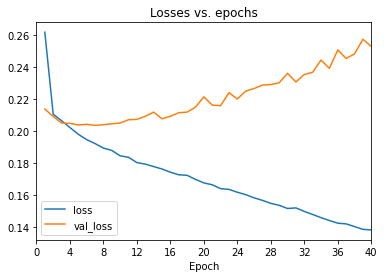

In [881]:
plot_history(baseline_history.history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

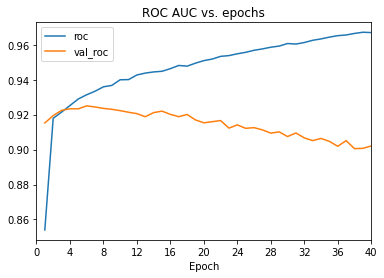

In [883]:
plot_history(baseline_history.history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

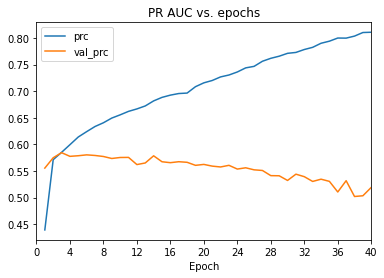

In [884]:
plot_history(baseline_history.history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

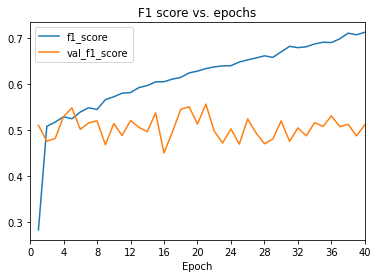

In [823]:
plot_history(baseline_history.history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

In [885]:
def plot_cm(labels, predictions, p=0.5):
  """Plots the confusion matrix based on the specified lables and predictions at p.

  Args:
      labels (_type_): _description_
      predictions (_type_): _description_
      p (float, optional): _description_. Defaults to 0.5.
  """
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True negatives: ', cm[0][0])
  print('False positives: ', cm[0][1])
  print('False negatives: ', cm[1][0])
  print('True positives: ', cm[1][1])
  print('Total positives: ', np.sum(cm[1]))

loss :  0.2530423104763031
roc :  0.9020730257034302
prc :  0.5191521048545837
f1_score :  0.49160119891166687

True negatives:  5560
False positives:  280
False negatives:  401
True positives:  340
Total positives:  741


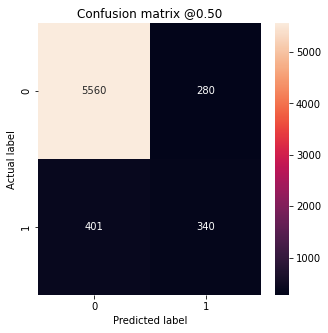

In [886]:
train_predictions_baseline = dnn_baseline.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_baseline = dnn_baseline.predict(x_val, batch_size=BATCH_SIZE)

baseline_results = dnn_baseline.evaluate(x_val, y_val,
                                         batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(dnn_baseline.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val, val_predictions_baseline, p=0.5)

ROC curve

In [887]:
def plot_roc(name, labels, predictions, **kwargs):
  """Plots the ROC curve
  """
  fp, tp, _ = metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

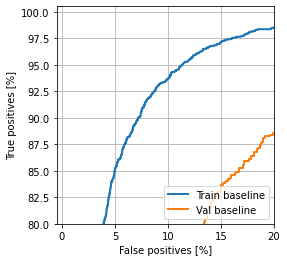

In [888]:
plot_roc("Train baseline", y_train, train_predictions_baseline)
plot_roc("Val baseline", y_val, val_predictions_baseline)
plt.legend(loc='lower right');

Precision/Recall (PR) curve

In [889]:
def plot_prc(name, labels, predictions, **kwargs):
    """Plots the precision/recall curve
    """
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

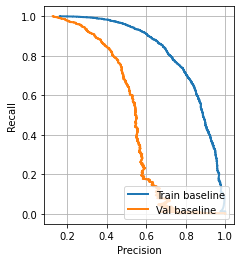

In [890]:
plot_prc("Train baseline", y_train, train_predictions_baseline)
plot_prc("Val baseline", y_val, val_predictions_baseline)
plt.legend(loc='lower right');

### Regularization
Drop-out layer to reduce overfitting

In [891]:
def get_regularized_dnn(learning_rate=0.001, drop_out_rate=0.5, print_summary=True):
    """Return a regularized DNN containing Dropout layers

    Args:
        learning_rate (float, optional): _description_. Defaults to 0.001.
        drop_out_rate (float, optional): _description_. Defaults to 0.5.
        print_summary (bool, optional): _description_. Defaults to True.

    Returns:
        Tensorflow object: The DNN
    """
    dropout_rate = drop_out_rate

    model = Sequential([
        Dense(units=64, activation='relu', input_dim=x_train.shape[1]),
        Dropout(dropout_rate),
        Dense(units=32, activation='relu'),
        Dropout(dropout_rate),
        Dense(units=16, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])

    opitimizer = Adam(learning_rate)
    model.compile(optimizer=opitimizer, loss='binary_crossentropy', metrics=[AUC(name='roc', curve='ROC'),
                                                                             AUC(name='prc', curve='PR'),
                                                                             f1_score])
    if print_summary:
        print(model.summary())
    
    return model

In [892]:
dnn_regularized = get_regularized_dnn()
reg_history = dnn_regularized.fit(x_train, y_train,
                                  validation_data=(x_val, y_val),
                                  batch_size=BATCH_SIZE,
                                  epochs=40,
                                  verbose=1)

Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_915 (Dense)           (None, 64)                3712      
                                                                 
 dropout_370 (Dropout)       (None, 64)                0         
                                                                 
 dense_916 (Dense)           (None, 32)                2080      
                                                                 
 dropout_371 (Dropout)       (None, 32)                0         
                                                                 
 dense_917 (Dense)           (None, 16)                528       
                                                                 
 dense_918 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trai

#### Results

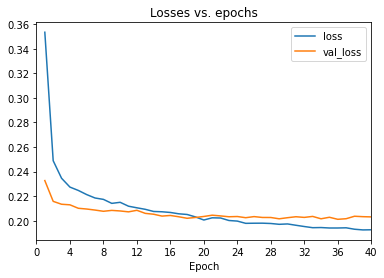

In [893]:
plot_history(reg_history.history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

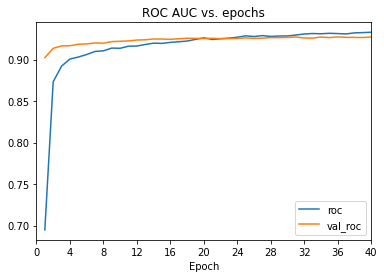

In [894]:
plot_history(reg_history.history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

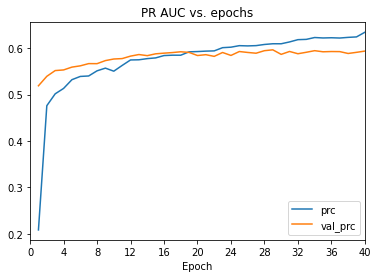

In [895]:
plot_history(reg_history.history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

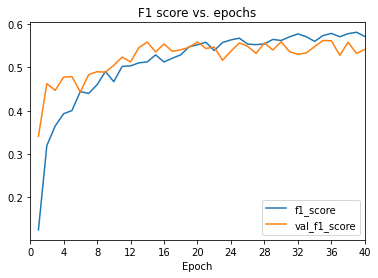

In [896]:
plot_history(reg_history.history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

loss :  0.2031257301568985
roc :  0.9272369742393494
prc :  0.5936683416366577
f1_score :  0.5415356159210205

True negatives:  5600
False positives:  240
False negatives:  367
True positives:  374
Total positives:  741


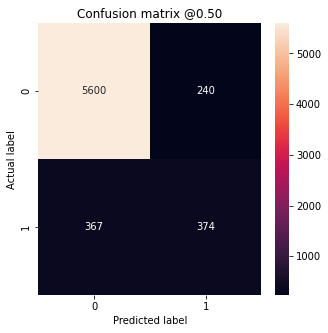

In [897]:
train_predictions_reg = dnn_regularized.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_reg = dnn_regularized.predict(x_val, batch_size=BATCH_SIZE)

reg_results = dnn_regularized.evaluate(x_val, y_val,
                                       batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(dnn_regularized.metrics_names, reg_results):
  print(name, ': ', value)
print()

plot_cm(y_val, val_predictions_reg, p=0.5)

ROC

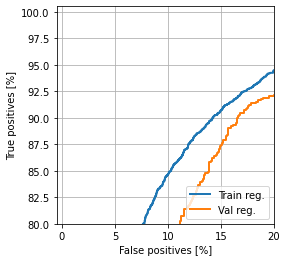

In [898]:
plot_roc("Train reg.", y_train, train_predictions_reg)
plot_roc("Val reg.", y_val, val_predictions_reg)
plt.legend(loc='lower right');

PR curve

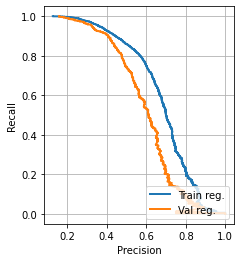

In [899]:
plot_prc("Train reg.", y_train, train_predictions_reg)
plot_prc("Val reg.", y_val, val_predictions_reg)
plt.legend(loc='lower right');

### Class weights

In [900]:
def print_train_val_metrics(model):
    """Prints metrics for training and evaluation data

    Args:
        model : The model to evaluate
    """
    train_results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
    val_results = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
    
    train_val_results = np.vstack([np.array(train_results).transpose(),
                                   np.array(val_results).transpose()]).transpose()
    
    result_df = pd.DataFrame(columns=['Training', 'Validation'], index=model.metrics_names, data=train_val_results)
    print(result_df)

In [738]:
def grid_search_dnn_weighted():
    learning_rates = [0.001, 0.005, 0.01]
    drop_out_rates = [0.3, 0.4, 0.5, 0.6]
    
    for learning_rate in learning_rates:
        for drop_out_rate in drop_out_rates:
            print(f'>>> Learning rate {learning_rate}, drop-out rate: {drop_out_rate}')
            
            dnn_weighted = get_regularized_dnn(learning_rate, drop_out_rate, print_summary=False)
            weighted_history = dnn_weighted.fit(x_train, y_train,
                                                validation_data=(x_val, y_val),
                                                batch_size=BATCH_SIZE,
                                                epochs=40,
                                                class_weight=class_weights,
                                                verbose=0)

            weighted_results = dnn_weighted.evaluate(x_val, y_val,
                                                    batch_size=BATCH_SIZE, verbose=0)
            #for name, value in zip(dnn_weighted.metrics_names, weighted_results):
            #    print(name, ': ', value)
            #print()
            print(print_train_val_metrics(dnn_weighted))

grid_search_dnn_weighted()

>>> Learning rate 0.001, drop-out rate: 0.3
          Training  Validation
loss      0.328781    0.379931
acc       0.842977    0.821760
roc       0.954354    0.922279
prc       0.676369    0.583521
f1_score  0.574604    0.529042
None
>>> Learning rate 0.001, drop-out rate: 0.4
          Training  Validation
loss      0.345066    0.377521
acc       0.828198    0.815378
roc       0.947014    0.926621
prc       0.650792    0.592012
f1_score  0.551148    0.526571
None
>>> Learning rate 0.001, drop-out rate: 0.5
          Training  Validation
loss      0.346438    0.370966
acc       0.830554    0.819328
roc       0.942362    0.927261
prc       0.619079    0.583331
f1_score  0.551465    0.531903
None
>>> Learning rate 0.001, drop-out rate: 0.6
          Training  Validation
loss      0.362678    0.376431
acc       0.819422    0.812491
roc       0.936129    0.928408
prc       0.602603    0.590105
f1_score  0.533582    0.524118
None
>>> Learning rate 0.005, drop-out rate: 0.3
          Traini

In [901]:
dnn_weighted = get_regularized_dnn()
weighted_history = dnn_weighted.fit(x_train, y_train,
                                    validation_data=(x_val, y_val),
                                    batch_size=BATCH_SIZE,
                                    epochs=40,
                                    class_weight=class_weights,
                                    verbose=1)

Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_919 (Dense)           (None, 64)                3712      
                                                                 
 dropout_372 (Dropout)       (None, 64)                0         
                                                                 
 dense_920 (Dense)           (None, 32)                2080      
                                                                 
 dropout_373 (Dropout)       (None, 32)                0         
                                                                 
 dense_921 (Dense)           (None, 16)                528       
                                                                 
 dense_922 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trai

#### Results

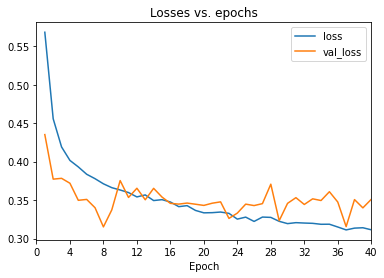

In [902]:
plot_history(weighted_history.history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

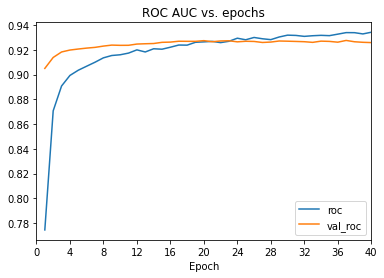

In [904]:
plot_history(weighted_history.history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

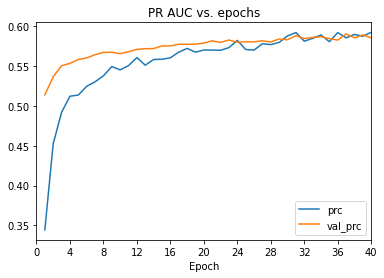

In [906]:
plot_history(weighted_history.history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

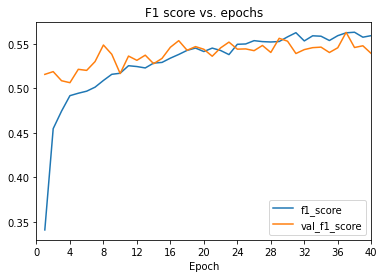

In [905]:
plot_history(weighted_history.history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

loss :  0.3509511947631836
roc :  0.9259451627731323
prc :  0.5856471061706543
f1_score :  0.53902667760849

True negatives:  4773
False positives:  1067
False negatives:  69
True positives:  672
Total positives:  741


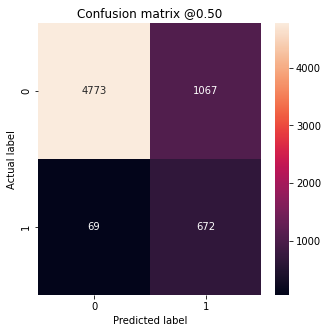

In [907]:
train_predictions_weighted = dnn_weighted.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_weighted = dnn_weighted.predict(x_val, batch_size=BATCH_SIZE)

baseline_results = dnn_weighted.evaluate(x_val, y_val,
                                         batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(dnn_weighted.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val, val_predictions_weighted, p=0.5)

ROC

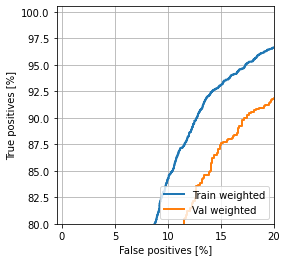

In [908]:
plot_roc("Train weighted", y_train, train_predictions_weighted)
plot_roc("Val weighted", y_val, val_predictions_weighted)
plt.legend(loc='lower right');

PR curve

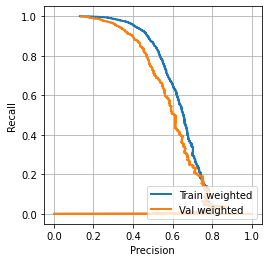

In [909]:
plot_prc("Train weighted", y_train, train_predictions_weighted)
plot_prc("Val weighted", y_val, val_predictions_weighted)
plt.legend(loc='lower right');

### Oversampling

In [910]:
def perform_oversampling(x, y):     
    print('Orig target balance:')
    print(y.y.value_counts())
    
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    x, y = ros.fit_resample(x, y)
    
    print('Resampled target balance:')
    print(y.y.value_counts())
    
    return x, y

In [913]:
train_data_os, target_os, train_encoder_os = get_processed_data('train_file.xlsx', oversample=True)

print(f'train_data shape: {train_data_os.shape}')
print(f'target shape: {target_os.shape}')

x_train_os, x_val_os, y_train_os, y_val_os = train_test_split(train_data_os, target_os,
                                                              train_size=0.8,
                                                              shuffle=True,
                                                              random_state=42,
                                                              stratify=target_os)

print(f'X train shape: {x_train_os.shape}; X test shape {x_val_os.shape}')
print(f'Y train shape: {y_train_os.shape}; Y test shape {y_val_os.shape}')

Loaded data shape: (32910, 15)
W/o duplicates: (32902, 15)
Orig target balance:
no     29195
yes     3707
Name: y, dtype: int64
Resampled target balance:
no     29195
yes    29195
Name: y, dtype: int64
Encoded data shape: (58390, 53)
train_data shape: (58390, 57)
target shape: (58390, 1)
X train shape: (46712, 57); X test shape (11678, 57)
Y train shape: (46712, 1); Y test shape (11678, 1)


In [914]:
dnn_os = get_regularized_dnn()
os_history = dnn_os.fit(x_train_os, y_train_os,
                         validation_data=(x_val_os, y_val_os),
                         batch_size=BATCH_SIZE,
                         epochs=60,
                         verbose=1)

Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_923 (Dense)           (None, 64)                3712      
                                                                 
 dropout_374 (Dropout)       (None, 64)                0         
                                                                 
 dense_924 (Dense)           (None, 32)                2080      
                                                                 
 dropout_375 (Dropout)       (None, 32)                0         
                                                                 
 dense_925 (Dense)           (None, 16)                528       
                                                                 
 dense_926 (Dense)           (None, 1)                 17        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trai

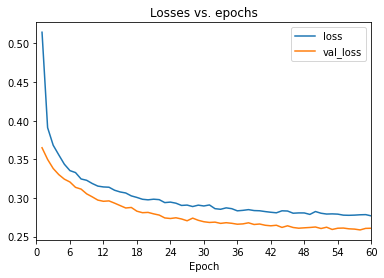

In [915]:
plot_history(os_history.history, train_label='loss', val_label='val_loss', title='Losses vs. epochs')

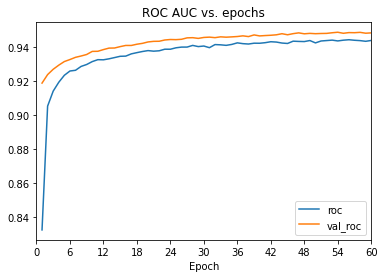

In [918]:
plot_history(os_history.history, train_label='roc', val_label='val_roc', title='ROC AUC vs. epochs')

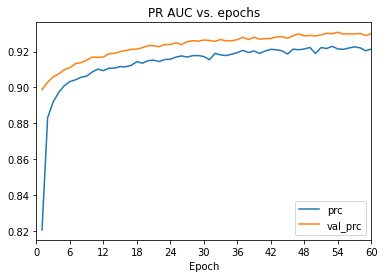

In [919]:
plot_history(os_history.history, train_label='prc', val_label='val_prc', title='PR AUC vs. epochs')

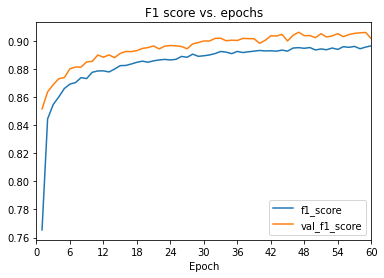

In [920]:
plot_history(os_history.history, train_label='f1_score', val_label='val_f1_score', title='F1 score vs. epochs')

Confusion matrix

loss :  0.3509511947631836
roc :  0.9259451627731323
prc :  0.5856471061706543
f1_score :  0.53902667760849

True negatives:  4873
False positives:  966
False negatives:  245
True positives:  5594
Total positives:  5839


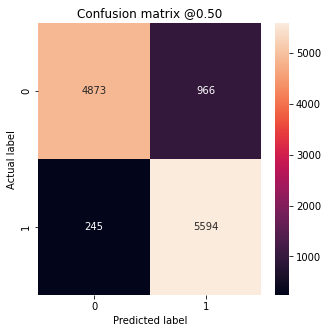

In [925]:
train_predictions_os = dnn_os.predict(x_train_os, batch_size=BATCH_SIZE)
val_predictions_os = dnn_os.predict(x_val_os, batch_size=BATCH_SIZE)

os_results = dnn_os.evaluate(x_val_os, y_val_os,
                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(dnn_os.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_val_os, val_predictions_os, p=0.5)

ROC

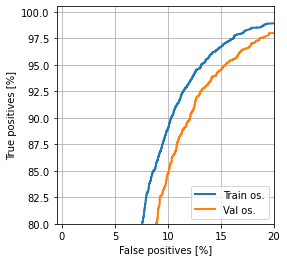

In [927]:
plot_roc("Train os.", y_train_os, train_predictions_os)
plot_roc("Val os.", y_val_os, val_predictions_os)
plt.legend(loc='lower right');

PR curve

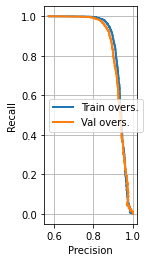

In [928]:
plot_prc("Train overs.", y_train_os, train_predictions_os)
plot_prc("Val overs.", y_val_os, val_predictions_os)
plt.legend(loc='center left');

## Test predictions

### Load test data

In [944]:
x_test = get_processed_data('test_file.xlsx', encoder=train_encoder, split_target=False)
print(f'x shape: {x_test.shape}')

Loaded data shape: (40, 14)
W/o duplicates: (40, 14)
Encoded data shape: (40, 53)
x shape: (40, 57)


### Generate predictions

### Write to CSV file

In [ ]:
# read file first to append predictions
test_file_name = 'test_predictions.csv'
test_predictions = pd.read_csv(test_file_name)

test_predictions.head()

In [ ]:
test_predictions.to_csv(test_file_name)